# Task 1 - Character level vanilla RNN

In [1]:
# importing dependencies

import itertools
import operator
import numpy as np
import nltk
import sys
import pandas as pd
import re
from datetime import datetime

import matplotlib.pyplot as plt

In [2]:
# reading the text files.

f = open("Text_1.txt","r")

if(f.mode == "r"):
    contents1 = f.read()
f.close()
f = open("Text_2.txt","r")

if(f.mode == "r"):
    contents2 = f.read()
f.close()

f = open("Text_4.txt","r")

if(f.mode == "r"):
    contents3 = f.read()
f.close()

In [3]:
# concatenating the texts
data = contents1+contents2+contents3

# changing upper case to lower case
data = data.lower()

In [4]:
# creating dictionaries for charater to number and number to character conversion.
chars = list(set(data))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

In [5]:
# splitting the data content into characters

def split(word): 
    return [char for char in word]

data = split(data)

# converting all the characters into numeric value using the char_to_idx dictionary

for ch in range(len(data)):
    data[ch] = char_to_idx[data[ch]]

In [6]:
# breaking the whole data content into lists of 20 characters each. This is the length of the input sequnce x

x = []
z =[]
i = 0
for t in range(len(data)):
    if t%20==0:
        x.append(z)
        z = []
    else:
        z.append(data[t])
        

In [7]:
# breacking the whole data content in lists of 20 characters each and create the training data y

x.remove(x[0])
last_char = data[0] 
data.remove(data[0])

y = []
z =[]
i = 0
for t in range(len(data)):
    if t%20==0:
        y.append(z)
        z = []
    else:
        z.append(data[t])
        
y.remove(y[0])
y[-1].append(last_char)
data.append(last_char)

In [8]:
# setting the vocabulary size as the number of unique characters in the data content

vocabulary_size = 68

In [9]:
# Creating the class RNNVanilla for RNN model

class RNNVanilla:
     
    def __init__(self, word_dim, hidden_dim=100, bptt_truncate=10):
        
        # Assign instance variables
        self.word_dim = word_dim   #size of the vocabulary
        self.hidden_dim = hidden_dim  # size of hidden layer
        self.bptt_truncate = bptt_truncate # words that the network will remember before predicting 
        
        # Randomly initialize the network parameters
        self.U = np.random.uniform(-np.sqrt(1./word_dim), np.sqrt(1./word_dim), (hidden_dim, word_dim))
        self.V = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (word_dim, hidden_dim))
        self.W = np.random.uniform(-np.sqrt(1./hidden_dim), np.sqrt(1./hidden_dim), (hidden_dim, hidden_dim))

# fucntion for softmax activation function
def softmax(x):
    xt = np.exp(x - np.max(x))
    return xt / np.sum(xt)

# function for forward propagation in rnn
def forward_propagation(self, x):
    # The total number of time steps
    T = len(x)
    
        # During forward propagation we save all hidden states in s because need them later.

        # We add one additional element for the initial hidden, which we set to 0
    s = np.zeros((T + 1, self.hidden_dim))
    s[-1] = np.zeros(self.hidden_dim)

        # The outputs at each time step. Again, we save them for later.
    o = np.zeros((T, self.word_dim))

        # For each time step...
    for t in np.arange(T):
            # Note that we are indxing U by x[t]. This is the same as multiplying U with a one-hot vector.
        #print(x)
        s[t] = np.tanh(self.U[:,x[t]] + self.W.dot(s[t-1]))
        o[t] = softmax(self.V.dot(s[t]))
    return [o, s]  #We not only return the calculated outputs, but also the hidden states. 
                       #We will use them later to calculate the gradients

#Now make it a member of the class RNNVanilla
RNNVanilla.forward_propagation = forward_propagation

# creating a function to predict text using forward propagation and return index of the highest score with the rnn model
def predict(self, x):
    o, s = self.forward_propagation(x)
    return np.argmax(o, axis=1)

#Now make it a member of the class RNNVanilla
RNNVanilla.predict = predict


In [10]:
# function to calculate total error from all the cells in the network.
def calculate_total_loss(self, x, y):
    L = 0
    
    # For each sentence...
    for i in np.arange(len(y)):
        o, s = self.forward_propagation(x[i])
        
        # We only care about our prediction of the "correct" words
        correct_word_predictions = o[np.arange(len(y[i])), y[i]]
        
        # Add to the loss based on how off we were
        L += -1 * sum(np.log(correct_word_predictions))
    return L

# function to divide the total loss by the number of training examples
def calculate_loss(self, x, y):
    N = sum((len(y_i) for y_i in y))
    return self.calculate_total_loss(x,y)/N
 
RNNVanilla.calculate_total_loss = calculate_total_loss
RNNVanilla.calculate_loss = calculate_loss

In [11]:
# function for back propagation through time for updating gradients 

def bptt(self, x, y):
    T = len(y)
    # Perform forward propagation
    o, s = self.forward_propagation(x)
    # We accumulate the gradients in these variables
    dLdU = np.zeros(self.U.shape)
    dLdV = np.zeros(self.V.shape)
    dLdW = np.zeros(self.W.shape)
    delta_o = o
    delta_o[np.arange(len(y)), y] -= 1.
    # For each output backwards...
    for t in np.arange(T)[::-1]:
        dLdV += np.outer(delta_o[t], s[t].T)
        
        # Initial delta calculation
        delta_t = self.V.T.dot(delta_o[t]) * (1 - (s[t] ** 2))
        
        # Backpropagation through time (for at most self.bptt_truncate steps)
        for bptt_step in np.arange(max(0, t-self.bptt_truncate), t+1)[::-1]:
            
            dLdW += np.outer(delta_t, s[bptt_step-1])              
            dLdU[:,x[bptt_step]] += delta_t
            
            # Update delta for next step
            delta_t = self.W.T.dot(delta_t) * (1 - s[bptt_step-1] ** 2)
    return [dLdU, dLdV, dLdW]
 
RNNVanilla.bptt = bptt

Performing gradient check for the model

In [12]:
 # Calculate the gradients using backpropagation. We want to checker if these are correct.

def gradient_check(self, x, y, h=0.001, error_threshold=0.01):
    bptt_gradients = self.bptt(x, y)
    
    # List of all parameters we want to check.
    model_parameters = ['U', 'V', 'W']
    
    # Gradient check for each parameter
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value from the mode, e.g. model.W
        parameter = operator.attrgetter(pname)(self)
        print ("Performing gradient check for parameter %s with size %d." % (pname, np.prod(parameter.shape)))
        # Iterate over each element of the parameter matrix, e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])
        while not it.finished:
            ix = it.multi_index
            # Save the original value so we can reset it later
            original_value = parameter[ix]
            # Estimate the gradient using (f(x+h) - f(x-h))/(2*h)
            parameter[ix] = original_value + h
            gradplus = self.calculate_total_loss([x],[y])
            parameter[ix] = original_value - h
            gradminus = self.calculate_total_loss([x],[y])
            estimated_gradient = (gradplus - gradminus)/(2*h)
            # Reset parameter to original value
            parameter[ix] = original_value
            # The gradient for this parameter calculated using backpropagation
            backprop_gradient = bptt_gradients[pidx][ix]
            # calculate The relative error: (|x - y|/(|x| + |y|))
            relative_error = np.abs(backprop_gradient - estimated_gradient)/(np.abs(backprop_gradient) + np.abs(estimated_gradient))
            # If the error is to large fail the gradient check
            if relative_error > error_threshold:
                print ("Gradient Check ERROR: parameter=%s ix=%s" % (pname, ix))
                print ("+h Loss: %f" % gradplus)
                print ("-h Loss: %f" % gradminus)
                print ("Estimated_gradient: %f" % estimated_gradient)
                print ("Backpropagation gradient: %f" % backprop_gradient)
                print ("Relative Error: %f" % relative_error)
                return
            it.iternext()
        print ("Gradient check for parameter %s passed." % (pname))

RNNVanilla.gradient_check = gradient_check

# To avoid performing millions of expensive calculations we use a smaller vocabulary size for checking.

grad_check_vocab_size = 100
np.random.seed(10)
model = RNNVanilla(grad_check_vocab_size, 10, bptt_truncate=1000)
model.gradient_check([1,0,4,3], [0,4,3,2])

Performing gradient check for parameter U with size 1000.


C:\Users\khare\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in double_scalars


Gradient check for parameter U passed.
Performing gradient check for parameter V with size 1000.
Gradient check for parameter V passed.
Performing gradient check for parameter W with size 100.
Gradient check for parameter W passed.


In [13]:
# function for adding gradient descent to the weights U,V and W

def numpy_sdg_step(self, x, y, learning_rate):
    # Calculate the gradients
    dLdU, dLdV, dLdW = self.bptt(x, y)
    # Change parameters according to gradients and learning rate
    self.U -= learning_rate * dLdU
    self.V -= learning_rate * dLdV
    self.W -= learning_rate * dLdW
    
RNNVanilla.sgd_step = numpy_sdg_step

In [14]:
# function of training the rnn model using stochastic gradient descent

def train_with_sgd(model, X_train, y_train, learning_rate=0.01, nepoch=100, evaluate_loss_after=5):
    # We keep track of the losses so we can plot them later
    losses = []
    num_examples_seen = 0
    for epoch in range(nepoch):
        # Optionally evaluate the loss
        if (epoch % evaluate_loss_after == 0):
            loss = model.calculate_loss(X_train, y_train)
            losses.append((num_examples_seen, loss))
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print ("%s: Loss after num_examples_seen=%d epoch=%d: %f" % (time, num_examples_seen, epoch, loss))
            # Adjust the learning rate if loss increases
            if (len(losses) > 1 and losses[-1][1] > losses[-2][1]):
                learning_rate = learning_rate * 0.5 
                print ("Setting learning rate to %f" % learning_rate)
            sys.stdout.flush()
        # For each training example...
        for i in range(len(y_train)):
            # One SGD step
            model.sgd_step(X_train[i], y_train[i], learning_rate)
            num_examples_seen += 1
    return losses

In [15]:
# Train our rnn model on a small subset of the data 

np.random.seed(10)
model = RNNVanilla(vocabulary_size)
losses = train_with_sgd(model, x[:500], y[:500], nepoch=20, evaluate_loss_after=4)

2019-11-07 20:51:14: Loss after num_examples_seen=0 epoch=0: 4.231144
2019-11-07 20:52:35: Loss after num_examples_seen=2000 epoch=4: 2.387671
2019-11-07 20:54:03: Loss after num_examples_seen=4000 epoch=8: 2.267130
2019-11-07 20:55:29: Loss after num_examples_seen=6000 epoch=12: 2.230215
2019-11-07 20:56:56: Loss after num_examples_seen=8000 epoch=16: 2.261835
Setting learning rate to 0.005000


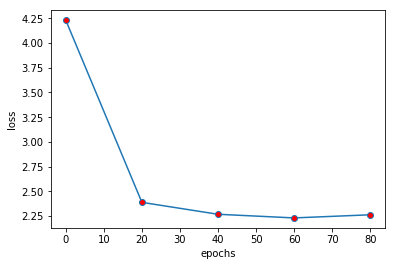

In [16]:
# Plotting a graph between the loss and number of epochs

losses_array = np.asarray(losses)

num_of_epochs = []
loss_per_epoch = []
for i in range(losses_array.shape[0]):
    num_of_epochs.append((losses_array[i][0])/100)
    loss_per_epoch.append(losses_array[i][1])
    
plt.plot(num_of_epochs,loss_per_epoch,marker ='o', markerfacecolor = 'red')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [17]:
# generating text using the model 

num_sentences = 10 # I am generating 10 sentences
sentence_max_length = 100 # each sentence has max length of 100 characters 

def generate_sentence(model,sentence_max_length):
    # We start the sentence with a random character here I have chosen 'a'
    new_sentence = [char_to_idx['a']]
    i = 0
    
    # Repeat until we get a sentence of desired length
    while i<sentence_max_length:
        next_word_probs = model.forward_propagation(new_sentence)
        next_word = next_word_probs[0]
        samples = np.random.multinomial(1, next_word[-1])
        sampled_word = np.argmax(samples)
        new_sentence.append(sampled_word)
        i = i+1
    sentence_str = [idx_to_char[x] for x in new_sentence[1:-1]]
    return sentence_str
 
    
for i in range(num_sentences):
    sent = []
    sent = generate_sentence(model,sentence_max_length)
    full = ("".join(sent))
    print(i+1," ",full)
    
# generating 10 sentences with this model

1   t oncte, and wasemebuly

i pueedaty ofhan the fienireed the chove hadh ioples.d hade fag itr thion 
2   nd and betavisuny taits pecalled meserfed fatl thalu ald fichire hamting of in hamelemy ut oo pofse
3   gincusels stepres caracre the fote: healy, twetlng fachened i. fay, a tine wishoud-os. oucves--/owr
4   nd ray ousess-onder ie havien iokurily'e he of astofiem ourdits, whie his ooftry larepre-giet-prosi
5   tedtcle, ho
eloucedtr'sed has nofelficelld
the hit onole!let bat bio has a ptonecomy eryale houdlit
6   dbfictainly

axourgory
many tesacy aclabely ancleared minel ind lesi>y, reares, and bes-fin tisure,
7   ldern cheary, the eale keicget rencomere las p.
cons can; acle to withe

obee, chamoist-y soupe tio
8   vederyned and a pealicutieal mache ay a tupbe ham fuchauld at fis oureouat

phrent stound it was ve
9   llt
wfud bescle, a wosle as
me mesles. to appersed gy tin happ westoreed nctely was onser,
mos.dadi
10   rnid, and asporedcoiee, tond
 hrandies a mistay itsealaged 

Analysis -> I have tried different hidden units values and trained the model the best results that I got were with 50 hidden units but overall the pattern of the graph does not show any major changes.